# Joining 100 million OpenStreetMap GPS points with US zip codes

This example is based on the benchmarks from the SciPy 2020 presentation titled "Spatial Algorithms at Scale with Spatialpandas" by Quansight. The original source can be found at https://github.com/Quansight/scipy2020_spatial_algorithms_at_scale

The dataset used here is a subset (for the US) of all GPS data from OpenStreetMap from June 2012 (freely available at https://planet.openstreetmap.org/gps/simple-gps-points-120604.csv.xz). This in itself is a 73 GB (uncompressed) CSV file containing 2.9 billion latitude/longitude point pairs only. The US subset used in this example has 114 million rows.

In [1]:
import geopandas
from shapely.geometry import box

import dask.dataframe as dd
import dask_geopandas

from pathlib import Path
import requests
import zipfile

In [2]:
import dask
from distributed import Client, LocalCluster

dask.config.set({"distributed.nanny.environ.MALLOC_TRIM_THRESHOLD_": 0})

cluster = LocalCluster(n_workers=1, threads_per_worker=4, memory_limit='10GB')
client = Client(cluster)

client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 1
Total threads: 4,Total memory: 9.31 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:39943,Workers: 1
Dashboard: http://127.0.0.1:8787/status,Total threads: 4
Started: Just now,Total memory: 9.31 GiB
Comm: tcp://127.0.0.1:40003,Total threads: 4
Dashboard: http://127.0.0.1:46291/status,Memory: 9.31 GiB
Nanny: tcp://127.0.0.1:35043,


## Download and prepare data

In [5]:
# set up data paths
base_path = Path().cwd()
data_dir = base_path / 'data'
zip_dir = data_dir / 'zip_codes'

### Zip code polygons

#### Download the zip code polygons

In [ ]:
# create title and url for zip code data
title = 'US Census Data - Zip Code Boundaries'
url = 'https://www2.census.gov/geo/tiger/TIGER2019/ZCTA5/tl_2019_us_zcta510.zip'

print(f"Downloading {title} \n    From: {url}\n    To: {zip_dir}")

# get the remote data (may take up to 30 minutes)
r = requests.get(url)
# convert to zipfile format
z = zipfile.ZipFile(io.BytesIO(r.content))
# extract the zip contents
z.extractall(zip_dir)

#### View and subset the polygons

In [3]:
gdf = geopandas.read_file(zip_dir / "tl_2019_us_zcta510/tl_2019_us_zcta510.shp")
gdf.head()

,ZCTA5CE10,GEOID10,CLASSFP10,MTFCC10,FUNCSTAT10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10,geometry
0,43451,43451,B5,G6350,S,63484186,157689,+41.3183010,-083.6174935,"POLYGON ((-83.70873 41.32733, -83.70815 41.327..."
1,43452,43452,B5,G6350,S,121522304,13721730,+41.5157923,-082.9809454,"POLYGON ((-83.08698 41.53780, -83.08256 41.537..."
2,43456,43456,B5,G6350,S,9320975,1003775,+41.6318300,-082.8393923,"MULTIPOLYGON (((-82.83558 41.71082, -82.83515 ..."
3,43457,43457,B5,G6350,S,48004681,0,+41.2673301,-083.4274872,"POLYGON ((-83.49650 41.25371, -83.48382 41.253..."
4,43458,43458,B5,G6350,S,2573816,39915,+41.5304461,-083.2133648,"POLYGON ((-83.22229 41.53102, -83.22228 41.532..."


In [5]:
len(gdf)

33144

Remove Alaska and overseas areas:

In [7]:
contiguous_us_bounding_box = box(-124.848974, 24.396308, -66.885444, 49.384358)

gdf_clipped = geopandas.clip(gdf, contiguous_us_bounding_box)

<AxesSubplot:>

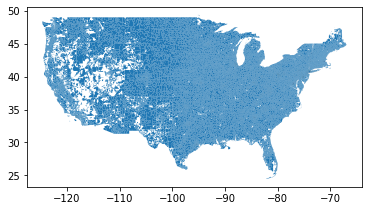

In [8]:
gdf_clipped.plot()

Save the subset to a Parquet file:

In [9]:
gdf_clipped.to_parquet(zip_dir / "zips.parquet")

In [13]:
# set up data paths
raw_data_dir = base_path.joinpath('../../benchmark-data')

### OpenStreetMap point data
Download from this url: `https://planet.openstreetmap.org/gps/simple-gps-points-120604.csv.xz`  
and place it in the `data` folder

In [ ]:
# unpack the xz data using the `unxz` package
! unxz -d data/simple-gps-points-120604.csv.xz

In [4]:
# set the output path
pt_data_path = data_dir.joinpath('contiguous_us.parquet')

In [18]:
# read in the csv point data
# ddf = dd.read_csv(data_dir / 'simple-gps-points-120604.csv', dtype={'altitude': 'float64'}).loc[:, ['latitude', 'longitude']]
ddf = dd.read_csv(base_path.joinpath('../../benchmark-data') / 'simple-gps-points-120604.csv', dtype={'altitude': 'float64'}).loc[:, ['latitude', 'longitude']]
# convert to degreess
ddf.latitude = ddf.latitude/10**7
ddf.longitude = ddf.longitude/10**7

In [19]:
ddf

,latitude,longitude
npartitions=1217,,
,float64,float64
,...,...
...,...,...
,...,...
,...,...


#### Extract the contiguous US and save as parquet

In [20]:
%%time 
# reduce osm data to continguous us
usdf = ddf[ddf.latitude.between(24.396308, 49.384358) & ddf.longitude.between(-124.848974, -66.885444)]
# write to file
usdf.to_parquet(data_dir / "simple-gps-points-us.parquet", engine='pyarrow', compression='snappy');

CPU times: user 44.1 s, sys: 4.29 s, total: 48.4 s
Wall time: 7min 34s


[None]

### Spatially partition the point data

In [8]:
ddf = dd.read_parquet(data_dir / "simple-gps-points-us.parquet", engine='pyarrow')

In [9]:
ddf

,latitude,longitude
npartitions=1217,,
,float64,float64
,...,...
...,...,...
,...,...
,...,...


In [10]:
len(ddf)

113944489

In the original Parquet dataset, we have 1217 partitions. However, many are empty because of the filtering step we did. Therefore, let's first repartition the dataset:

In [11]:
ddf_repartitioned = ddf.repartition(partition_size="20MB")

In [12]:
%%time
ddf_repartitioned.to_parquet(data_dir / "simple-gps-points-us-repartitioned.parquet");

CPU times: user 6.6 s, sys: 273 ms, total: 6.87 s
Wall time: 21.6 s


[None]

In [13]:
ddf = dd.read_parquet(data_dir / "simple-gps-points-us-repartitioned.parquet", engine='pyarrow')

In [14]:
ddf

,latitude,longitude
npartitions=180,,
,float64,float64
,...,...
...,...,...
,...,...
,...,...


Converting the dataset to a geospatial dataset:

In [15]:
# gddf = dask_geopandas.from_dask_dataframe(ddf, geometry=dask_geopandas.points_from_xy(ddf, "longitude", 'longitude'))

In [16]:
gddf = ddf.set_geometry(dask_geopandas.points_from_xy(ddf, "longitude", "latitude", crs="EPSG:4326"))

In [18]:
gddf

,latitude,longitude,geometry
npartitions=180,,,
,float64,float64,geometry
,...,...,...
...,...,...,...
,...,...,...
,...,...,...


In [19]:
%%time
gddf[["geometry"]].to_parquet(data_dir / "simple-gps-points-us-spatial.parquet");

/home/joris/scipy/geopandas/geopandas/geoseries.py:51: FutureWarning:     You are passing non-geometry data to the GeoSeries constructor. Currently,
    it falls back to returning a pandas Series. But in the future, we will start
    to raise a TypeError instead.
  return GeoSeries(data=data, index=index, crs=crs, **kwargs)


CPU times: user 12.1 s, sys: 967 ms, total: 13.1 s
Wall time: 2min 53s


[None]

In [20]:
gddf = dask_geopandas.read_parquet(data_dir / "simple-gps-points-us-spatial.parquet")

In [21]:
%%time
(gddf.spatial_shuffle(by="hilbert", shuffle="disk", calculate_partitions=False)
     .to_parquet(data_dir / "simple-gps-points-us-spatiallysorted.parquet"));

distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 6.52 GiB -- Worker memory limit: 9.31 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 6.71 GiB -- Worker memory limit: 9.31 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 6.71 GiB -- Worker memory limit: 9.31 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see 

CPU times: user 46.5 s, sys: 3.29 s, total: 49.8 s
Wall time: 9min 29s


[None]

In [23]:
ggdf = dask_geopandas.read_parquet(data_dir / "simple-gps-points-us-spatiallysorted.parquet")

In [24]:
ggdf

,geometry
npartitions=180,
102518,geometry
412913167,...
...,...
4084029550,...
4294880706,...


In [26]:
ggdf.spatial_partitions.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [27]:
ggdf.spatial_partitions.explore()

<AxesSubplot:>

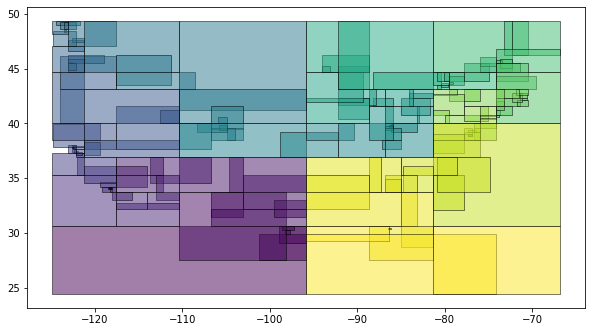

In [28]:
ggdf.spatial_partitions.plot(cmap="viridis", alpha=0.5, edgecolor="k", figsize=(10, 6))

In [29]:
zip_codes = geopandas.read_parquet(zip_dir / "zips.parquet")

In [32]:
zip_codes.to_crs("EPSG:4326")

,ZCTA5CE10,GEOID10,CLASSFP10,MTFCC10,FUNCSTAT10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10,geometry
23501,95421,95421,B5,G6350,S,561075419,810418,+38.6282167,-123.1608338,"POLYGON ((-123.40285 38.64939, -123.40275 38.6..."
23497,95412,95412,B5,G6350,S,221922988,0,+38.7134214,-123.3497767,"POLYGON ((-123.49739 38.77855, -123.49705 38.7..."
31434,95497,95497,B5,G6350,S,41786078,277559,+38.7252743,-123.4583140,"POLYGON ((-123.53354 38.76840, -123.53340 38.7..."
23757,95445,95445,B5,G6350,S,221559099,7363179,+38.8325203,-123.4725321,"POLYGON ((-123.64690 38.84301, -123.64510 38.8..."
31433,95494,95494,B5,G6350,S,266620289,0,+38.8896506,-123.3378211,"POLYGON ((-123.46585 38.91151, -123.46580 38.9..."
...,...,...,...,...,...,...,...,...,...,...
19907,98281,98281,B5,G6350,S,12652172,4389065,+48.9919302,-123.0511838,"POLYGON ((-123.08935 49.00206, -123.07880 49.0..."
20744,98305,98305,B5,G6350,S,310452900,2764632,+48.0628908,-124.4390723,"POLYGON ((-124.62593 48.08373, -124.62585 48.0..."
11123,98326,98326,B5,G6350,S,754263710,32608364,+48.1811984,-124.4120541,"POLYGON ((-124.73642 48.17139, -124.73617 48.1..."
12227,98381,98381,B5,G6350,S,174374033,0,+48.2737011,-124.4749340,"POLYGON ((-124.62307 48.26323, -124.62295 48.2..."


In [33]:
zip_codes = _

In [34]:
joined = dask_geopandas.sjoin(gddf, zip_codes, how='inner', predicate="within")

In [37]:
counts = joined.groupby("ZCTA5CE10")["GEOID10"].count()

In [40]:
df_counts = counts.compute()

distributed.nanny - WARNING - Restarting worker


In [39]:
joined["ZCTA5CE10"].value_counts()

Dask Series Structure:
npartitions=1
    int64
      ...
Name: ZCTA5CE10, dtype: int64
Dask Name: value-counts-agg, 748 tasks

In [41]:
df_counts

ZCTA5CE10
33001    2325
33030     460
33031      76
33032    2242
33033    1803
         ... 
99153     192
99157     302
99160     444
56741      36
56711     368
Name: GEOID10, Length: 22756, dtype: int64

In [44]:
zip_codes_joined = zip_codes.merge(df_counts.rename("count").reset_index(), on="ZCTA5CE10")

In [47]:
zip_codes_joined["count_scaled"] = zip_codes_joined["count"] / zip_codes_joined.geometry.area

/tmp/ipykernel_17201/2683417817.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  zip_codes_joined["count_scaled"] = zip_codes_joined["count"] / zip_codes_joined.geometry.area


<AxesSubplot:>

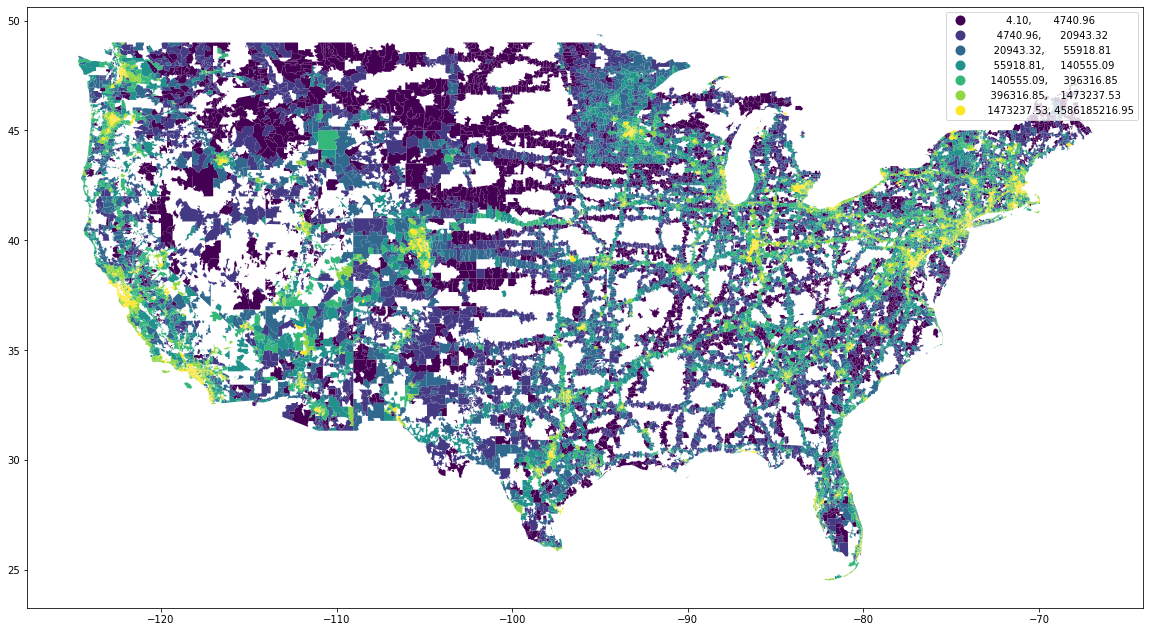

In [55]:
zip_codes_joined.plot(column="count_scaled", scheme="Quantiles", k=7, legend=True, figsize=(20, 20))

In [22]:
import ctypes

def trim_memory() -> int:
    libc = ctypes.CDLL("libc.so.6")
    return libc.malloc_trim(0)

client.run(trim_memory)


{'tcp://127.0.0.1:40003': 1}

In [ ]:
# release the dask workers
cluster.scale(0)